# Face Generation
In this project, we'll use generative adversarial networks to generate new images of faces.
### Get the Data
We'll be using two datasets in this project:
- MNIST
- CelebA



If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'

# e.g.     floyd run --gpu --mode jupyter notebook --data R5KrjnANiKVhLWAkpXhNBe


import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. We can view the first number of examples by changing `show_n_images`. 

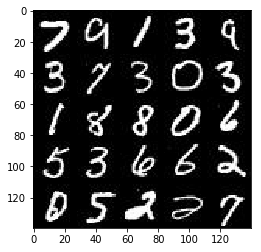

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  We can view the first number of examples by changing `show_n_images`.

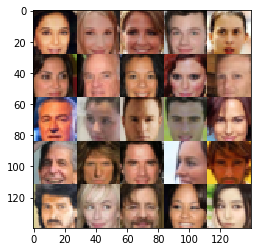

In [3]:
show_n_images = 25


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network


### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha = 0.1 # try 0.8?
    dropout = 0.3
    with tf.variable_scope('discriminator', reuse=reuse):
        
        def leaky_relu(x, alpha=alpha, name='leaky_relu'): 
            return tf.maximum(x, alpha * x, name=name)
        
        #  64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
          # leaky relu 
        x1 = leaky_relu(x1)
        # dropout
        x1 = tf.layers.dropout(x1, rate=dropout, training=True)
        
        #  128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, use_bias=False, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
          # batch normalisation and leaky relu
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2)
        # dropout
        x2 = tf.layers.dropout(x2, rate=dropout, training=True)
        
        #  256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, use_bias=False, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
          # batch normalisation and leaky relu
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3)
        # dropout
        x3 = tf.layers.dropout(x3, rate=dropout, training=True)
        
        # flatten layer
        flat = tf.reshape(x3, (-1, 4*4*256))
        # output layer
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits



tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [42]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    dropout = 0.3
    alpha = 0.1
    with tf.variable_scope('generator', reuse= not is_train):
        
        def leaky_relu(x, alpha=alpha, name='leaky_relu'): 
            return tf.maximum(x, alpha * x, name=name)
        
        
        
        # first fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # reshape to 4*4*512
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        
          ## batch normalisation and leaky relu
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        

        # 2nd layer - conv_t - change to (7*7*256)
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, use_bias=False ,padding='valid', 
                                         kernel_initializer=tf.contrib.layers.xavier_initializer())
          ## batch normalisation and leaky relu
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # dropout
        x2 = tf.layers.dropout(x2, rate=dropout, training=is_train)


        # 3rd layer - conv_t - change to (14*14*128)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, use_bias=False, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
          ## batch normalisation and leaky relu
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # dropout
        x3 = tf.layers.dropout(x3, rate=dropout, training=is_train)
        
        # output layer - (28*28*out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

    return tf.tanh(logits)



tests.test_generator(generator, tf)

Tests Passed


In [54]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    dropout = 0.3
    alpha = 0.1
    with tf.variable_scope('generator', reuse= not is_train):
        
        def leaky_relu(x, alpha=alpha, name='leaky_relu'): 
            return tf.maximum(x, alpha * x, name=name)
        
        
        
        # first fully connected layer
        x1 = tf.layers.dense(z, 2*2*1024)
        
        # reshape to 4*4*512
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        
          ## batch normalisation and leaky relu
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
    
#         print(x1.shape)
        
        # 2nd layer - conv_t - change to (4*4*512)
        x1 = tf.layers.conv2d_transpose(x1, 512, 3, strides=1, use_bias=False ,padding='valid', 
                                         kernel_initializer=tf.contrib.layers.xavier_initializer())
          ## batch normalisation and leaky relu
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # dropout
        x1 = tf.layers.dropout(x1, rate=dropout, training=is_train)

#         print(x1.shape)
        
        
        
        # 2nd layer - conv_t - change to (7*7*256)
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, use_bias=False ,padding='valid', 
                                         kernel_initializer=tf.contrib.layers.xavier_initializer())
          ## batch normalisation and leaky relu
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # dropout
        x2 = tf.layers.dropout(x2, rate=dropout, training=is_train)

#         print(x2.shape)
        
        # 3rd layer - conv_t - change to (14*14*128)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, use_bias=False, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
          ## batch normalisation and leaky relu
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # dropout
        x3 = tf.layers.dropout(x3, rate=dropout, training=is_train)
        
#         print(x3.shape)
        # output layer - (28*28*out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
#         print(logits.shape)

    return tf.tanh(logits)



tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # generator output
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # discriminator output
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss



tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)    
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training.

In [13]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_real, input_z, _ = model_inputs(data_shape[1], 
                                                      data_shape[2], 
                                                      data_shape[3], 
                                                      z_dim)
#     out_channel_dim = 1 if data_image_mode == 'L' else 3
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])#

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
#     saver = tf.train.Saver()
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    steps = 0


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # sample random noise for Generator
                
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
#                 _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 25 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}: Step {}...".format(epoch_i+1, steps+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 36, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1: Step 26... Discriminator Loss: 3.1867... Generator Loss: 0.1794
Epoch 1: Step 51... Discriminator Loss: 1.6955... Generator Loss: 0.5026
Epoch 1: Step 76... Discriminator Loss: 1.1533... Generator Loss: 1.8336
Epoch 1: Step 101... Discriminator Loss: 1.2674... Generator Loss: 1.5144


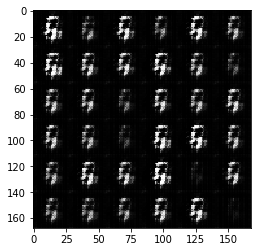

Epoch 1: Step 126... Discriminator Loss: 1.9850... Generator Loss: 1.2545
Epoch 1: Step 151... Discriminator Loss: 1.3755... Generator Loss: 0.8085
Epoch 1: Step 176... Discriminator Loss: 1.4960... Generator Loss: 1.0696
Epoch 1: Step 201... Discriminator Loss: 1.4058... Generator Loss: 0.7487


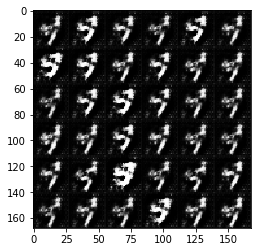

Epoch 1: Step 226... Discriminator Loss: 1.4423... Generator Loss: 0.6840
Epoch 1: Step 251... Discriminator Loss: 1.7767... Generator Loss: 0.7211
Epoch 1: Step 276... Discriminator Loss: 1.2628... Generator Loss: 0.6938
Epoch 1: Step 301... Discriminator Loss: 1.4427... Generator Loss: 1.1818


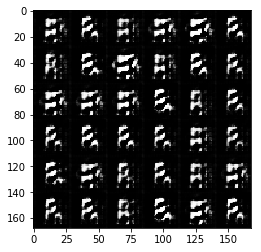

Epoch 1: Step 326... Discriminator Loss: 1.4765... Generator Loss: 0.7309
Epoch 1: Step 351... Discriminator Loss: 1.4964... Generator Loss: 1.1898
Epoch 1: Step 376... Discriminator Loss: 1.0555... Generator Loss: 1.1534
Epoch 1: Step 401... Discriminator Loss: 1.3764... Generator Loss: 0.7125


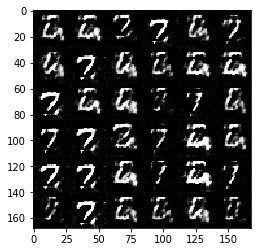

Epoch 1: Step 426... Discriminator Loss: 1.1281... Generator Loss: 1.1033
Epoch 1: Step 451... Discriminator Loss: 1.4383... Generator Loss: 1.5661
Epoch 1: Step 476... Discriminator Loss: 1.6510... Generator Loss: 1.9383
Epoch 1: Step 501... Discriminator Loss: 1.3778... Generator Loss: 0.8973


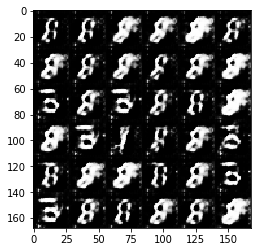

Epoch 1: Step 526... Discriminator Loss: 1.3920... Generator Loss: 0.5361
Epoch 1: Step 551... Discriminator Loss: 1.6334... Generator Loss: 0.5151
Epoch 1: Step 576... Discriminator Loss: 1.5291... Generator Loss: 0.5409
Epoch 1: Step 601... Discriminator Loss: 1.2647... Generator Loss: 1.4538


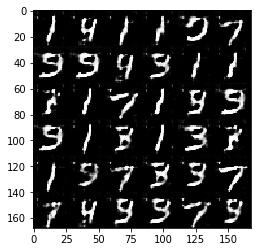

Epoch 1: Step 626... Discriminator Loss: 1.2843... Generator Loss: 0.7798
Epoch 1: Step 651... Discriminator Loss: 1.2068... Generator Loss: 0.8795
Epoch 1: Step 676... Discriminator Loss: 1.4074... Generator Loss: 0.7918
Epoch 1: Step 701... Discriminator Loss: 1.5171... Generator Loss: 1.1161


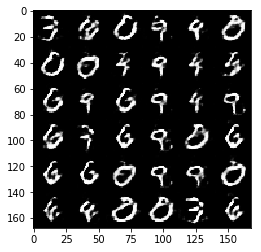

Epoch 1: Step 726... Discriminator Loss: 1.2808... Generator Loss: 0.8616
Epoch 1: Step 751... Discriminator Loss: 1.3568... Generator Loss: 0.5833
Epoch 1: Step 776... Discriminator Loss: 1.3175... Generator Loss: 1.4231
Epoch 1: Step 801... Discriminator Loss: 1.4723... Generator Loss: 0.6212


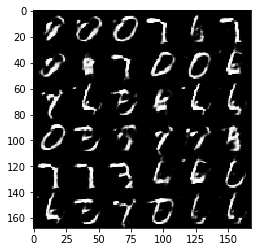

Epoch 1: Step 826... Discriminator Loss: 1.2482... Generator Loss: 0.8628
Epoch 1: Step 851... Discriminator Loss: 1.2466... Generator Loss: 1.1517
Epoch 1: Step 876... Discriminator Loss: 1.3576... Generator Loss: 1.2353
Epoch 1: Step 901... Discriminator Loss: 1.1816... Generator Loss: 0.7408


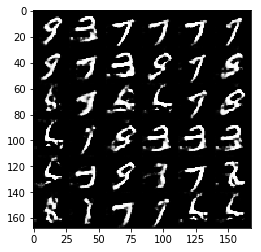

Epoch 1: Step 926... Discriminator Loss: 1.5750... Generator Loss: 0.4200
Epoch 2: Step 951... Discriminator Loss: 1.2022... Generator Loss: 1.1879
Epoch 2: Step 976... Discriminator Loss: 1.2641... Generator Loss: 1.2493
Epoch 2: Step 1001... Discriminator Loss: 1.4404... Generator Loss: 0.5618


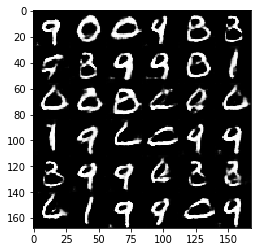

Epoch 2: Step 1026... Discriminator Loss: 1.5961... Generator Loss: 0.4663
Epoch 2: Step 1051... Discriminator Loss: 1.4134... Generator Loss: 0.5765
Epoch 2: Step 1076... Discriminator Loss: 1.3941... Generator Loss: 0.6554
Epoch 2: Step 1101... Discriminator Loss: 1.4218... Generator Loss: 0.7603


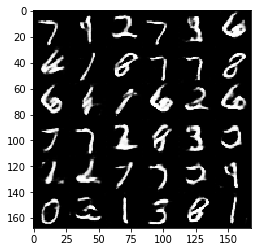

Epoch 2: Step 1126... Discriminator Loss: 1.2754... Generator Loss: 0.8037
Epoch 2: Step 1151... Discriminator Loss: 1.6178... Generator Loss: 1.4806
Epoch 2: Step 1176... Discriminator Loss: 1.3458... Generator Loss: 0.9370
Epoch 2: Step 1201... Discriminator Loss: 1.5306... Generator Loss: 0.5014


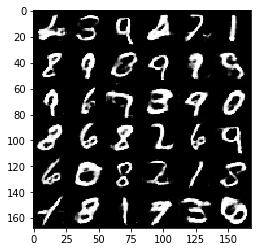

Epoch 2: Step 1226... Discriminator Loss: 1.4112... Generator Loss: 0.7952
Epoch 2: Step 1251... Discriminator Loss: 1.4540... Generator Loss: 0.6106
Epoch 2: Step 1276... Discriminator Loss: 1.3370... Generator Loss: 0.8873
Epoch 2: Step 1301... Discriminator Loss: 1.2358... Generator Loss: 1.0514


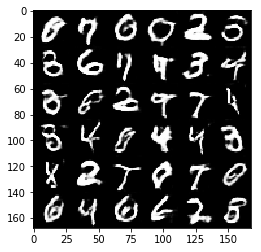

Epoch 2: Step 1326... Discriminator Loss: 1.3247... Generator Loss: 0.8790
Epoch 2: Step 1351... Discriminator Loss: 1.2878... Generator Loss: 0.8410
Epoch 2: Step 1376... Discriminator Loss: 1.2413... Generator Loss: 0.8852
Epoch 2: Step 1401... Discriminator Loss: 1.5197... Generator Loss: 1.5320


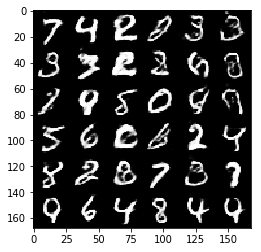

Epoch 2: Step 1426... Discriminator Loss: 1.4118... Generator Loss: 0.5740
Epoch 2: Step 1451... Discriminator Loss: 1.4693... Generator Loss: 0.4751
Epoch 2: Step 1476... Discriminator Loss: 1.3501... Generator Loss: 0.7302
Epoch 2: Step 1501... Discriminator Loss: 1.3572... Generator Loss: 0.6995


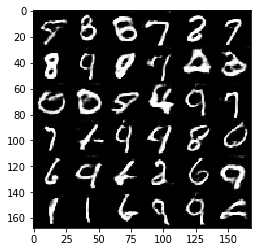

Epoch 2: Step 1526... Discriminator Loss: 1.2889... Generator Loss: 0.7397
Epoch 2: Step 1551... Discriminator Loss: 1.3164... Generator Loss: 0.9496
Epoch 2: Step 1576... Discriminator Loss: 1.3807... Generator Loss: 0.6763
Epoch 2: Step 1601... Discriminator Loss: 1.5118... Generator Loss: 0.5643


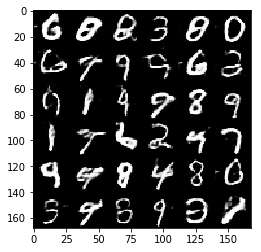

Epoch 2: Step 1626... Discriminator Loss: 1.2702... Generator Loss: 1.1114
Epoch 2: Step 1651... Discriminator Loss: 1.3275... Generator Loss: 0.9941
Epoch 2: Step 1676... Discriminator Loss: 1.6176... Generator Loss: 1.5742
Epoch 2: Step 1701... Discriminator Loss: 1.3097... Generator Loss: 0.6792


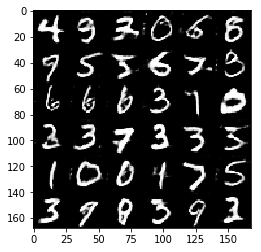

Epoch 2: Step 1726... Discriminator Loss: 1.4109... Generator Loss: 1.3783
Epoch 2: Step 1751... Discriminator Loss: 1.2656... Generator Loss: 0.8946
Epoch 2: Step 1776... Discriminator Loss: 1.3167... Generator Loss: 0.8487
Epoch 2: Step 1801... Discriminator Loss: 1.4078... Generator Loss: 0.6158


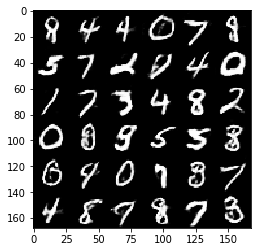

Epoch 2: Step 1826... Discriminator Loss: 1.2450... Generator Loss: 0.8412
Epoch 2: Step 1851... Discriminator Loss: 1.2968... Generator Loss: 0.6957


In [56]:
"""
add one layer to generator 1024
"""
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3

# tf.reset_default_graph()


epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1: Step 26... Discriminator Loss: 3.5740... Generator Loss: 0.0860
Epoch 1: Step 51... Discriminator Loss: 0.8778... Generator Loss: 2.7246
Epoch 1: Step 76... Discriminator Loss: 1.0819... Generator Loss: 1.2649
Epoch 1: Step 101... Discriminator Loss: 1.6795... Generator Loss: 0.5487


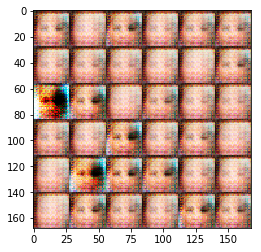

Epoch 1: Step 126... Discriminator Loss: 1.5381... Generator Loss: 0.6501
Epoch 1: Step 151... Discriminator Loss: 1.6226... Generator Loss: 0.8251
Epoch 1: Step 176... Discriminator Loss: 1.4762... Generator Loss: 1.4778
Epoch 1: Step 201... Discriminator Loss: 1.4087... Generator Loss: 0.7894


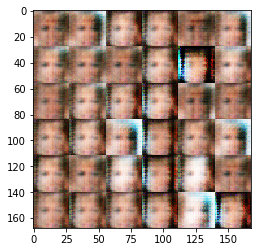

Epoch 1: Step 226... Discriminator Loss: 1.4547... Generator Loss: 0.6918
Epoch 1: Step 251... Discriminator Loss: 1.3739... Generator Loss: 1.1021
Epoch 1: Step 276... Discriminator Loss: 1.4380... Generator Loss: 0.6425
Epoch 1: Step 301... Discriminator Loss: 1.4297... Generator Loss: 0.9494


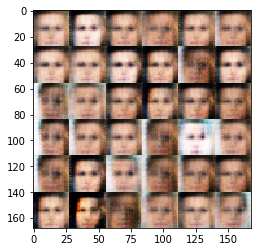

Epoch 1: Step 326... Discriminator Loss: 1.4243... Generator Loss: 1.0390
Epoch 1: Step 351... Discriminator Loss: 1.4061... Generator Loss: 0.9906
Epoch 1: Step 376... Discriminator Loss: 1.5523... Generator Loss: 0.6065
Epoch 1: Step 401... Discriminator Loss: 1.4578... Generator Loss: 0.9434


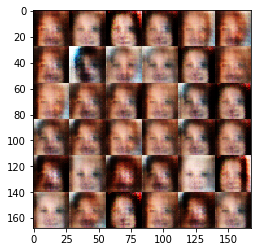

Epoch 1: Step 426... Discriminator Loss: 1.3864... Generator Loss: 0.7739
Epoch 1: Step 451... Discriminator Loss: 1.3142... Generator Loss: 0.8187
Epoch 1: Step 476... Discriminator Loss: 1.5354... Generator Loss: 0.6038
Epoch 1: Step 501... Discriminator Loss: 1.4442... Generator Loss: 0.8290


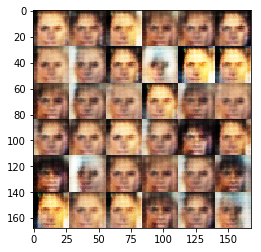

Epoch 1: Step 526... Discriminator Loss: 1.4092... Generator Loss: 0.7919
Epoch 1: Step 551... Discriminator Loss: 1.4404... Generator Loss: 0.9785
Epoch 1: Step 576... Discriminator Loss: 1.3651... Generator Loss: 1.0557
Epoch 1: Step 601... Discriminator Loss: 1.6867... Generator Loss: 0.4812


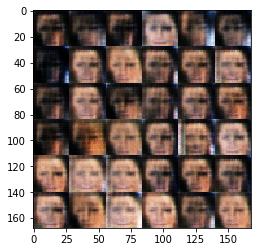

Epoch 1: Step 626... Discriminator Loss: 1.2840... Generator Loss: 0.8048
Epoch 1: Step 651... Discriminator Loss: 1.4405... Generator Loss: 0.6736
Epoch 1: Step 676... Discriminator Loss: 1.5123... Generator Loss: 0.6876
Epoch 1: Step 701... Discriminator Loss: 1.5049... Generator Loss: 0.6147


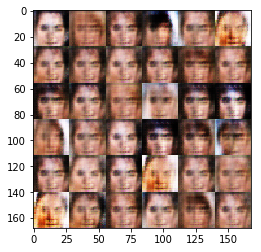

Epoch 1: Step 726... Discriminator Loss: 1.3999... Generator Loss: 0.8682
Epoch 1: Step 751... Discriminator Loss: 1.4926... Generator Loss: 0.9451
Epoch 1: Step 776... Discriminator Loss: 1.5270... Generator Loss: 0.9734
Epoch 1: Step 801... Discriminator Loss: 1.4098... Generator Loss: 0.6820


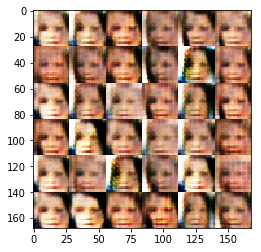

Epoch 1: Step 826... Discriminator Loss: 1.3016... Generator Loss: 0.9848
Epoch 1: Step 851... Discriminator Loss: 1.7914... Generator Loss: 0.3308
Epoch 1: Step 876... Discriminator Loss: 1.3503... Generator Loss: 0.8601
Epoch 1: Step 901... Discriminator Loss: 1.3379... Generator Loss: 0.9035


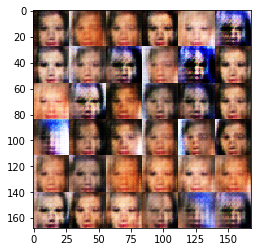

Epoch 1: Step 926... Discriminator Loss: 1.4511... Generator Loss: 0.5901
Epoch 1: Step 951... Discriminator Loss: 1.2600... Generator Loss: 0.8938
Epoch 1: Step 976... Discriminator Loss: 1.4005... Generator Loss: 0.8037
Epoch 1: Step 1001... Discriminator Loss: 1.4815... Generator Loss: 0.8067


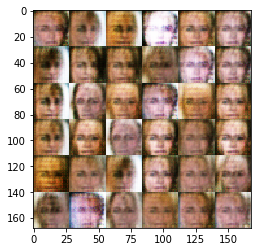

Epoch 1: Step 1026... Discriminator Loss: 1.3184... Generator Loss: 0.8096
Epoch 1: Step 1051... Discriminator Loss: 1.3023... Generator Loss: 0.8771
Epoch 1: Step 1076... Discriminator Loss: 1.4245... Generator Loss: 0.8652
Epoch 1: Step 1101... Discriminator Loss: 1.3744... Generator Loss: 0.7361


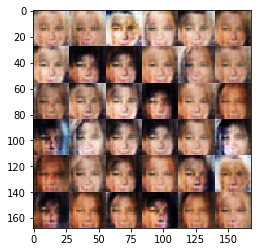

Epoch 1: Step 1126... Discriminator Loss: 1.4324... Generator Loss: 1.0235
Epoch 1: Step 1151... Discriminator Loss: 1.4355... Generator Loss: 0.7146
Epoch 1: Step 1176... Discriminator Loss: 1.3397... Generator Loss: 0.8646
Epoch 1: Step 1201... Discriminator Loss: 1.3183... Generator Loss: 0.8348


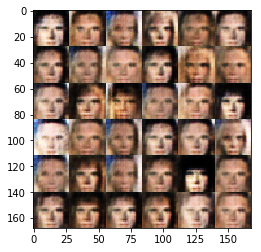

Epoch 1: Step 1226... Discriminator Loss: 1.4034... Generator Loss: 0.6784
Epoch 1: Step 1251... Discriminator Loss: 1.4861... Generator Loss: 0.7160
Epoch 1: Step 1276... Discriminator Loss: 1.4379... Generator Loss: 0.9289
Epoch 1: Step 1301... Discriminator Loss: 1.3060... Generator Loss: 0.8362


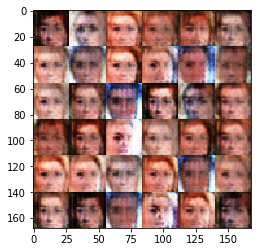

Epoch 1: Step 1326... Discriminator Loss: 1.4327... Generator Loss: 1.0069
Epoch 1: Step 1351... Discriminator Loss: 1.4069... Generator Loss: 0.7485
Epoch 1: Step 1376... Discriminator Loss: 1.3896... Generator Loss: 0.6951
Epoch 1: Step 1401... Discriminator Loss: 1.3395... Generator Loss: 0.8200


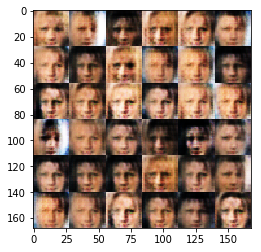

Epoch 1: Step 1426... Discriminator Loss: 1.3679... Generator Loss: 0.8356
Epoch 1: Step 1451... Discriminator Loss: 1.3643... Generator Loss: 0.7633
Epoch 1: Step 1476... Discriminator Loss: 1.4409... Generator Loss: 0.7383
Epoch 1: Step 1501... Discriminator Loss: 1.4267... Generator Loss: 0.6906


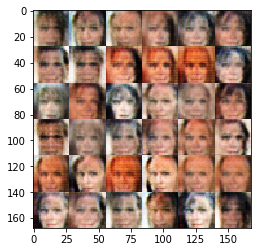

Epoch 1: Step 1526... Discriminator Loss: 1.3606... Generator Loss: 0.9130
Epoch 1: Step 1551... Discriminator Loss: 1.4587... Generator Loss: 0.8754
Epoch 1: Step 1576... Discriminator Loss: 1.3746... Generator Loss: 0.7016
Epoch 1: Step 1601... Discriminator Loss: 1.3510... Generator Loss: 0.7778


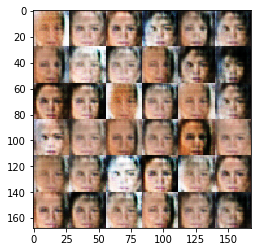

Epoch 1: Step 1626... Discriminator Loss: 1.4001... Generator Loss: 0.7106
Epoch 1: Step 1651... Discriminator Loss: 1.3042... Generator Loss: 0.8325
Epoch 1: Step 1676... Discriminator Loss: 1.3516... Generator Loss: 0.7948
Epoch 1: Step 1701... Discriminator Loss: 1.3812... Generator Loss: 0.8712


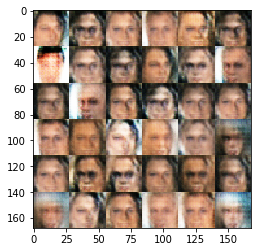

Epoch 1: Step 1726... Discriminator Loss: 1.3880... Generator Loss: 0.8856
Epoch 1: Step 1751... Discriminator Loss: 1.3911... Generator Loss: 0.8922
Epoch 1: Step 1776... Discriminator Loss: 1.3579... Generator Loss: 0.7889
Epoch 1: Step 1801... Discriminator Loss: 1.3204... Generator Loss: 0.9771


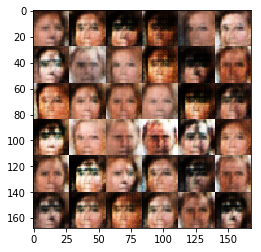

Epoch 1: Step 1826... Discriminator Loss: 1.4447... Generator Loss: 0.6648
Epoch 1: Step 1851... Discriminator Loss: 1.4134... Generator Loss: 0.7883
Epoch 1: Step 1876... Discriminator Loss: 1.4064... Generator Loss: 0.8771
Epoch 1: Step 1901... Discriminator Loss: 1.4293... Generator Loss: 0.8445


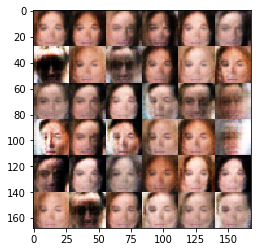

Epoch 1: Step 1926... Discriminator Loss: 1.3571... Generator Loss: 0.8486
Epoch 1: Step 1951... Discriminator Loss: 1.3978... Generator Loss: 0.8361
Epoch 1: Step 1976... Discriminator Loss: 1.3720... Generator Loss: 0.7082
Epoch 1: Step 2001... Discriminator Loss: 1.3551... Generator Loss: 0.6642


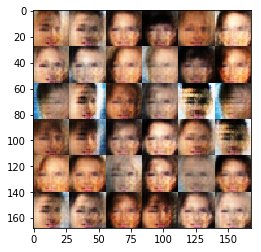

Epoch 1: Step 2026... Discriminator Loss: 1.4329... Generator Loss: 0.6057
Epoch 1: Step 2051... Discriminator Loss: 1.3341... Generator Loss: 0.7511
Epoch 1: Step 2076... Discriminator Loss: 1.3741... Generator Loss: 0.7085
Epoch 1: Step 2101... Discriminator Loss: 1.4588... Generator Loss: 0.7864


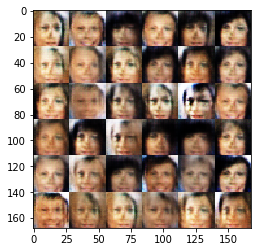

Epoch 1: Step 2126... Discriminator Loss: 1.3726... Generator Loss: 0.8072
Epoch 1: Step 2151... Discriminator Loss: 1.3347... Generator Loss: 0.8520
Epoch 1: Step 2176... Discriminator Loss: 1.3558... Generator Loss: 0.7830
Epoch 1: Step 2201... Discriminator Loss: 1.3707... Generator Loss: 0.8429


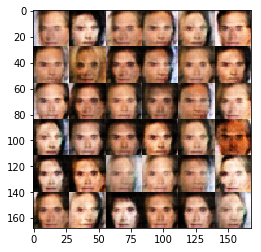

Epoch 1: Step 2226... Discriminator Loss: 1.3706... Generator Loss: 0.7076
Epoch 1: Step 2251... Discriminator Loss: 1.3651... Generator Loss: 0.7029
Epoch 1: Step 2276... Discriminator Loss: 1.3602... Generator Loss: 0.8258
Epoch 1: Step 2301... Discriminator Loss: 1.3694... Generator Loss: 0.8389


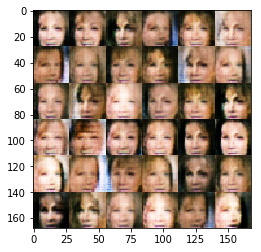

Epoch 1: Step 2326... Discriminator Loss: 1.3626... Generator Loss: 0.7477
Epoch 1: Step 2351... Discriminator Loss: 1.3720... Generator Loss: 0.8015
Epoch 1: Step 2376... Discriminator Loss: 1.3643... Generator Loss: 0.7647
Epoch 1: Step 2401... Discriminator Loss: 1.4274... Generator Loss: 0.6634


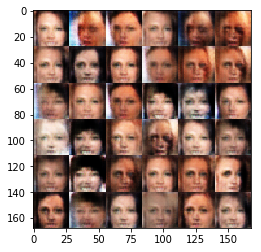

Epoch 1: Step 2426... Discriminator Loss: 1.3976... Generator Loss: 0.8188
Epoch 1: Step 2451... Discriminator Loss: 1.4275... Generator Loss: 0.6462
Epoch 1: Step 2476... Discriminator Loss: 1.4235... Generator Loss: 0.8430
Epoch 1: Step 2501... Discriminator Loss: 1.3632... Generator Loss: 0.8787


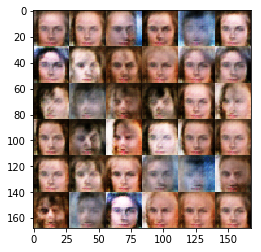

Epoch 1: Step 2526... Discriminator Loss: 1.5556... Generator Loss: 0.5610
Epoch 1: Step 2551... Discriminator Loss: 1.4902... Generator Loss: 0.6399
Epoch 1: Step 2576... Discriminator Loss: 1.2931... Generator Loss: 0.8228
Epoch 1: Step 2601... Discriminator Loss: 1.3497... Generator Loss: 0.8003


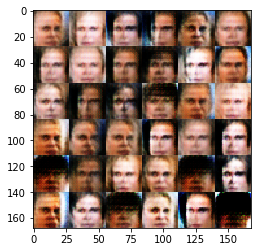

Epoch 1: Step 2626... Discriminator Loss: 1.4865... Generator Loss: 0.5737
Epoch 1: Step 2651... Discriminator Loss: 1.3108... Generator Loss: 0.8257
Epoch 1: Step 2676... Discriminator Loss: 1.3506... Generator Loss: 0.7795
Epoch 1: Step 2701... Discriminator Loss: 1.3580... Generator Loss: 0.8588


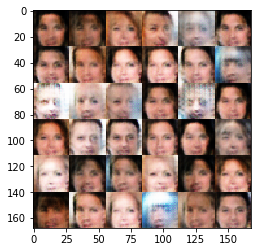

Epoch 1: Step 2726... Discriminator Loss: 1.3629... Generator Loss: 0.7081
Epoch 1: Step 2751... Discriminator Loss: 1.3485... Generator Loss: 0.7315
Epoch 1: Step 2776... Discriminator Loss: 1.4315... Generator Loss: 0.8618
Epoch 1: Step 2801... Discriminator Loss: 1.3723... Generator Loss: 0.7988


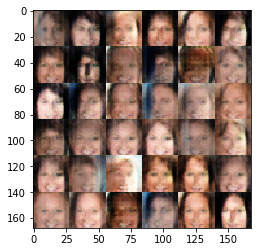

Epoch 1: Step 2826... Discriminator Loss: 1.3367... Generator Loss: 0.8274
Epoch 1: Step 2851... Discriminator Loss: 1.3706... Generator Loss: 0.7206
Epoch 1: Step 2876... Discriminator Loss: 1.3668... Generator Loss: 0.6700
Epoch 1: Step 2901... Discriminator Loss: 1.3125... Generator Loss: 0.7949


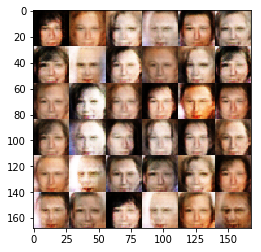

Epoch 1: Step 2926... Discriminator Loss: 1.4191... Generator Loss: 0.8969
Epoch 1: Step 2951... Discriminator Loss: 1.4003... Generator Loss: 0.8360
Epoch 1: Step 2976... Discriminator Loss: 1.5210... Generator Loss: 0.4962
Epoch 1: Step 3001... Discriminator Loss: 1.3602... Generator Loss: 0.8459


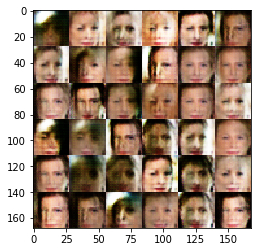

Epoch 1: Step 3026... Discriminator Loss: 1.3806... Generator Loss: 0.8974
Epoch 1: Step 3051... Discriminator Loss: 1.3469... Generator Loss: 0.7348
Epoch 1: Step 3076... Discriminator Loss: 1.3894... Generator Loss: 0.8167
Epoch 1: Step 3101... Discriminator Loss: 1.5354... Generator Loss: 0.5710


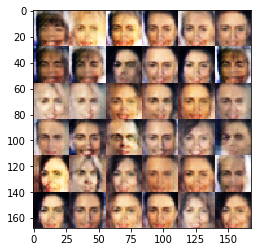

Epoch 1: Step 3126... Discriminator Loss: 1.3941... Generator Loss: 0.8500
Epoch 1: Step 3151... Discriminator Loss: 1.3784... Generator Loss: 0.8226
Epoch 2: Step 3176... Discriminator Loss: 1.3838... Generator Loss: 0.8827
Epoch 2: Step 3201... Discriminator Loss: 1.3644... Generator Loss: 0.8088


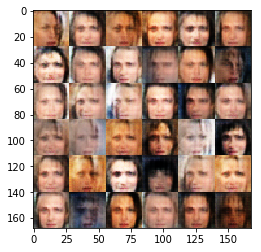

Epoch 2: Step 3226... Discriminator Loss: 1.3401... Generator Loss: 0.8717
Epoch 2: Step 3251... Discriminator Loss: 1.3603... Generator Loss: 0.7908
Epoch 2: Step 3276... Discriminator Loss: 1.3455... Generator Loss: 0.7906
Epoch 2: Step 3301... Discriminator Loss: 1.3527... Generator Loss: 0.7883


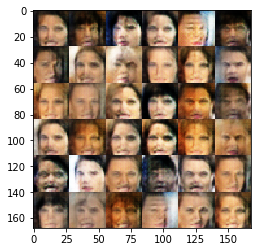

Epoch 2: Step 3326... Discriminator Loss: 1.3206... Generator Loss: 0.7609
Epoch 2: Step 3351... Discriminator Loss: 1.4164... Generator Loss: 0.8421
Epoch 2: Step 3376... Discriminator Loss: 1.3731... Generator Loss: 0.8169
Epoch 2: Step 3401... Discriminator Loss: 1.4176... Generator Loss: 0.8517


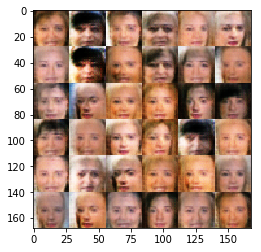

Epoch 2: Step 3426... Discriminator Loss: 1.3448... Generator Loss: 0.8269
Epoch 2: Step 3451... Discriminator Loss: 1.3956... Generator Loss: 0.8245
Epoch 2: Step 3476... Discriminator Loss: 1.3976... Generator Loss: 0.7054
Epoch 2: Step 3501... Discriminator Loss: 1.3441... Generator Loss: 0.8847


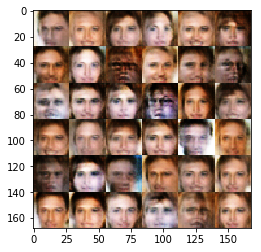

Epoch 2: Step 3526... Discriminator Loss: 1.3948... Generator Loss: 0.7741
Epoch 2: Step 3551... Discriminator Loss: 1.3519... Generator Loss: 0.8182
Epoch 2: Step 3576... Discriminator Loss: 1.3652... Generator Loss: 0.7969
Epoch 2: Step 3601... Discriminator Loss: 1.3968... Generator Loss: 0.8071


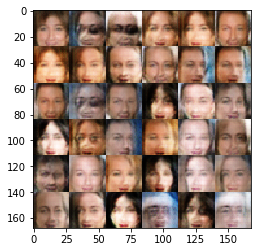

Epoch 2: Step 3626... Discriminator Loss: 1.4026... Generator Loss: 0.7050
Epoch 2: Step 3651... Discriminator Loss: 1.3359... Generator Loss: 0.8363
Epoch 2: Step 3676... Discriminator Loss: 1.3979... Generator Loss: 0.8218
Epoch 2: Step 3701... Discriminator Loss: 1.4112... Generator Loss: 0.7254


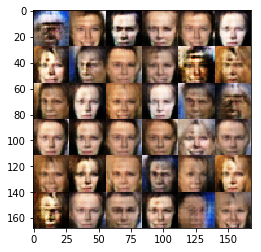

Epoch 2: Step 3726... Discriminator Loss: 1.3777... Generator Loss: 0.8015
Epoch 2: Step 3751... Discriminator Loss: 1.3608... Generator Loss: 0.7408
Epoch 2: Step 3776... Discriminator Loss: 1.3710... Generator Loss: 0.8163
Epoch 2: Step 3801... Discriminator Loss: 1.3846... Generator Loss: 0.8834


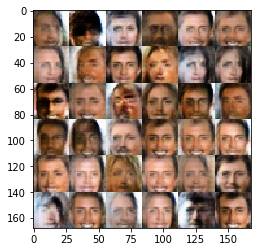

Epoch 2: Step 3826... Discriminator Loss: 1.4021... Generator Loss: 0.7664
Epoch 2: Step 3851... Discriminator Loss: 1.3530... Generator Loss: 0.7712
Epoch 2: Step 3876... Discriminator Loss: 1.3852... Generator Loss: 0.8867
Epoch 2: Step 3901... Discriminator Loss: 1.3494... Generator Loss: 0.9237


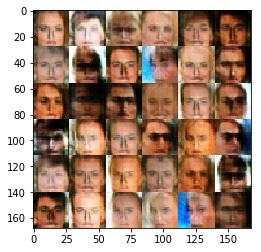

Epoch 2: Step 3926... Discriminator Loss: 1.3823... Generator Loss: 0.7969
Epoch 2: Step 3951... Discriminator Loss: 1.3832... Generator Loss: 0.8194
Epoch 2: Step 3976... Discriminator Loss: 1.3817... Generator Loss: 0.8033
Epoch 2: Step 4001... Discriminator Loss: 1.4438... Generator Loss: 0.7038


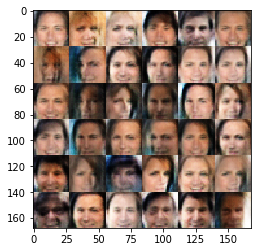

Epoch 2: Step 4026... Discriminator Loss: 1.3463... Generator Loss: 0.7859
Epoch 2: Step 4051... Discriminator Loss: 1.3672... Generator Loss: 0.7795
Epoch 2: Step 4076... Discriminator Loss: 1.3720... Generator Loss: 0.7398
Epoch 2: Step 4101... Discriminator Loss: 1.3831... Generator Loss: 0.8258


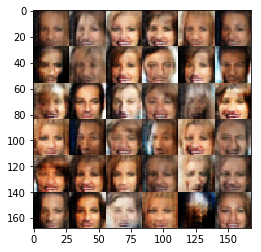

Epoch 2: Step 4126... Discriminator Loss: 1.3733... Generator Loss: 0.8269
Epoch 2: Step 4151... Discriminator Loss: 1.3655... Generator Loss: 0.7654
Epoch 2: Step 4176... Discriminator Loss: 1.3390... Generator Loss: 0.8069
Epoch 2: Step 4201... Discriminator Loss: 1.4065... Generator Loss: 0.7835


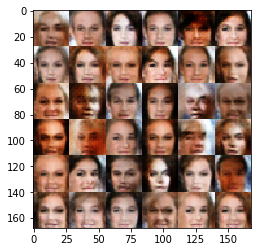

Epoch 2: Step 4226... Discriminator Loss: 1.3526... Generator Loss: 0.8528
Epoch 2: Step 4251... Discriminator Loss: 1.4083... Generator Loss: 0.8387
Epoch 2: Step 4276... Discriminator Loss: 1.3415... Generator Loss: 0.8767
Epoch 2: Step 4301... Discriminator Loss: 1.3631... Generator Loss: 0.8274


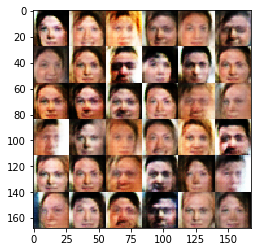

Epoch 2: Step 4326... Discriminator Loss: 1.3538... Generator Loss: 0.8170
Epoch 2: Step 4351... Discriminator Loss: 1.3320... Generator Loss: 0.8427
Epoch 2: Step 4376... Discriminator Loss: 1.3427... Generator Loss: 0.8260
Epoch 2: Step 4401... Discriminator Loss: 1.3400... Generator Loss: 0.7248


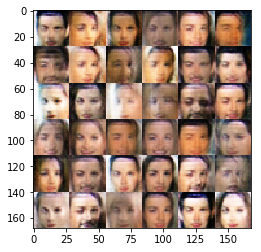

Epoch 2: Step 4426... Discriminator Loss: 1.3766... Generator Loss: 0.8111
Epoch 2: Step 4451... Discriminator Loss: 1.3289... Generator Loss: 0.7636
Epoch 2: Step 4476... Discriminator Loss: 1.3821... Generator Loss: 0.7579
Epoch 2: Step 4501... Discriminator Loss: 1.3991... Generator Loss: 0.9402


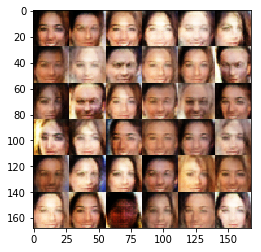

Epoch 2: Step 4526... Discriminator Loss: 1.3854... Generator Loss: 0.8587
Epoch 2: Step 4551... Discriminator Loss: 1.4098... Generator Loss: 0.7503
Epoch 2: Step 4576... Discriminator Loss: 1.3185... Generator Loss: 0.7486
Epoch 2: Step 4601... Discriminator Loss: 1.3866... Generator Loss: 0.9308


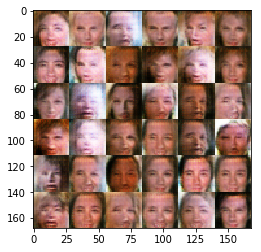

Epoch 2: Step 4626... Discriminator Loss: 1.3859... Generator Loss: 0.6936
Epoch 2: Step 4651... Discriminator Loss: 1.3188... Generator Loss: 0.8072
Epoch 2: Step 4676... Discriminator Loss: 1.4271... Generator Loss: 0.7380
Epoch 2: Step 4701... Discriminator Loss: 1.4116... Generator Loss: 0.7669


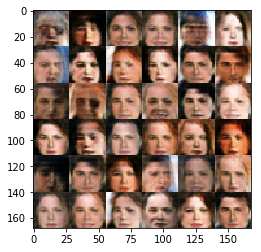

Epoch 2: Step 4726... Discriminator Loss: 1.3244... Generator Loss: 0.7777
Epoch 2: Step 4751... Discriminator Loss: 1.3730... Generator Loss: 0.7872
Epoch 2: Step 4776... Discriminator Loss: 1.4094... Generator Loss: 0.8240
Epoch 2: Step 4801... Discriminator Loss: 1.3914... Generator Loss: 0.7425


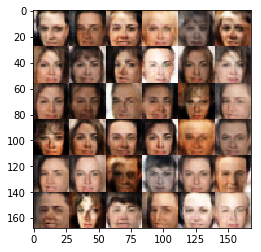

Epoch 2: Step 4826... Discriminator Loss: 1.3802... Generator Loss: 0.7065
Epoch 2: Step 4851... Discriminator Loss: 1.3682... Generator Loss: 0.8466
Epoch 2: Step 4876... Discriminator Loss: 1.3953... Generator Loss: 0.8732
Epoch 2: Step 4901... Discriminator Loss: 1.4008... Generator Loss: 0.8288


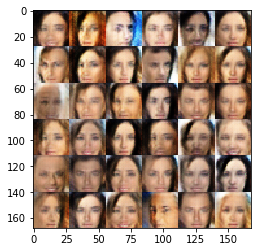

Epoch 2: Step 4926... Discriminator Loss: 1.4360... Generator Loss: 0.6441
Epoch 2: Step 4951... Discriminator Loss: 1.3518... Generator Loss: 0.8075
Epoch 2: Step 4976... Discriminator Loss: 1.3549... Generator Loss: 0.8517
Epoch 2: Step 5001... Discriminator Loss: 1.3828... Generator Loss: 0.8134


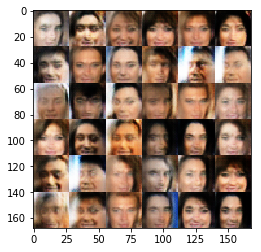

Epoch 2: Step 5026... Discriminator Loss: 1.3656... Generator Loss: 0.8071
Epoch 2: Step 5051... Discriminator Loss: 1.3861... Generator Loss: 0.7340
Epoch 2: Step 5076... Discriminator Loss: 1.3676... Generator Loss: 0.7633
Epoch 2: Step 5101... Discriminator Loss: 1.3607... Generator Loss: 0.8435


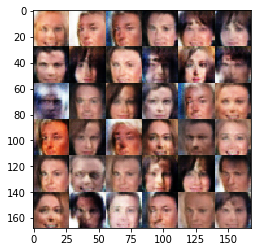

Epoch 2: Step 5126... Discriminator Loss: 1.4276... Generator Loss: 0.7094
Epoch 2: Step 5151... Discriminator Loss: 1.4199... Generator Loss: 0.7575
Epoch 2: Step 5176... Discriminator Loss: 1.3653... Generator Loss: 0.7474
Epoch 2: Step 5201... Discriminator Loss: 1.3524... Generator Loss: 0.8403


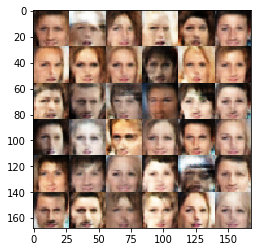

Epoch 2: Step 5226... Discriminator Loss: 1.3739... Generator Loss: 0.8046
Epoch 2: Step 5251... Discriminator Loss: 1.3892... Generator Loss: 0.9250
Epoch 2: Step 5276... Discriminator Loss: 1.3653... Generator Loss: 0.7274
Epoch 2: Step 5301... Discriminator Loss: 1.3617... Generator Loss: 0.7739


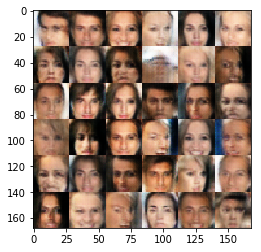

Epoch 2: Step 5326... Discriminator Loss: 1.3694... Generator Loss: 0.8003
Epoch 2: Step 5351... Discriminator Loss: 1.3564... Generator Loss: 0.8822
Epoch 2: Step 5376... Discriminator Loss: 1.4002... Generator Loss: 0.7866
Epoch 2: Step 5401... Discriminator Loss: 1.3238... Generator Loss: 0.8209


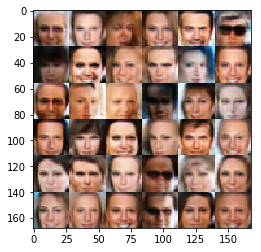

Epoch 2: Step 5426... Discriminator Loss: 1.3829... Generator Loss: 0.7822
Epoch 2: Step 5451... Discriminator Loss: 1.3904... Generator Loss: 0.7950
Epoch 2: Step 5476... Discriminator Loss: 1.3736... Generator Loss: 0.7510
Epoch 2: Step 5501... Discriminator Loss: 1.3490... Generator Loss: 0.8141


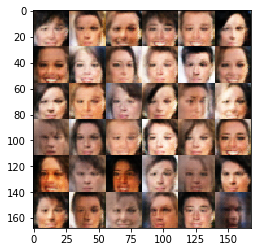

Epoch 2: Step 5526... Discriminator Loss: 1.3403... Generator Loss: 0.8195
Epoch 2: Step 5551... Discriminator Loss: 1.3629... Generator Loss: 0.7440
Epoch 2: Step 5576... Discriminator Loss: 1.3916... Generator Loss: 0.8327
Epoch 2: Step 5601... Discriminator Loss: 1.3128... Generator Loss: 0.8797


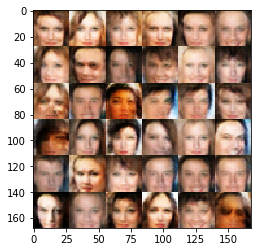

Epoch 2: Step 5626... Discriminator Loss: 1.3927... Generator Loss: 0.7456
Epoch 2: Step 5651... Discriminator Loss: 1.3904... Generator Loss: 0.6953
Epoch 2: Step 5676... Discriminator Loss: 1.3382... Generator Loss: 0.7937
Epoch 2: Step 5701... Discriminator Loss: 1.3676... Generator Loss: 0.8496


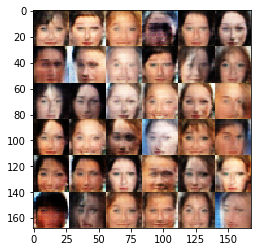

Epoch 2: Step 5726... Discriminator Loss: 1.3447... Generator Loss: 0.8264
Epoch 2: Step 5751... Discriminator Loss: 1.3547... Generator Loss: 0.7326
Epoch 2: Step 5776... Discriminator Loss: 1.3673... Generator Loss: 0.8363
Epoch 2: Step 5801... Discriminator Loss: 1.3754... Generator Loss: 0.8407


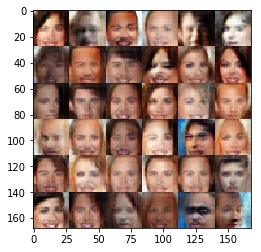

Epoch 2: Step 5826... Discriminator Loss: 1.3845... Generator Loss: 0.8551
Epoch 2: Step 5851... Discriminator Loss: 1.3954... Generator Loss: 0.8746
Epoch 2: Step 5876... Discriminator Loss: 1.4384... Generator Loss: 0.6783
Epoch 2: Step 5901... Discriminator Loss: 1.3429... Generator Loss: 0.8165


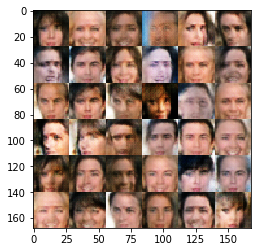

Epoch 2: Step 5926... Discriminator Loss: 1.3729... Generator Loss: 0.6755
Epoch 2: Step 5951... Discriminator Loss: 1.3977... Generator Loss: 0.7241
Epoch 2: Step 5976... Discriminator Loss: 1.3203... Generator Loss: 0.8238
Epoch 2: Step 6001... Discriminator Loss: 1.3444... Generator Loss: 0.7572


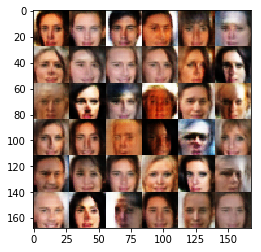

Epoch 2: Step 6026... Discriminator Loss: 1.3553... Generator Loss: 0.7643
Epoch 2: Step 6051... Discriminator Loss: 1.3743... Generator Loss: 0.8361
Epoch 2: Step 6076... Discriminator Loss: 1.3633... Generator Loss: 0.8387
Epoch 2: Step 6101... Discriminator Loss: 1.3873... Generator Loss: 0.8607


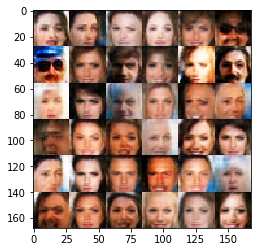

Epoch 2: Step 6126... Discriminator Loss: 1.3315... Generator Loss: 0.7846
Epoch 2: Step 6151... Discriminator Loss: 1.3678... Generator Loss: 0.8255
Epoch 2: Step 6176... Discriminator Loss: 1.3488... Generator Loss: 0.8758
Epoch 2: Step 6201... Discriminator Loss: 1.3715... Generator Loss: 0.6648


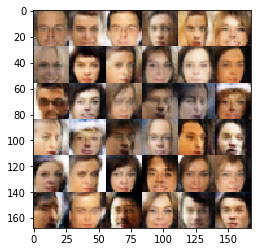

Epoch 2: Step 6226... Discriminator Loss: 1.4348... Generator Loss: 0.7430
Epoch 2: Step 6251... Discriminator Loss: 1.4085... Generator Loss: 0.6685
Epoch 2: Step 6276... Discriminator Loss: 1.3716... Generator Loss: 0.7119
Epoch 2: Step 6301... Discriminator Loss: 1.3901... Generator Loss: 0.8753


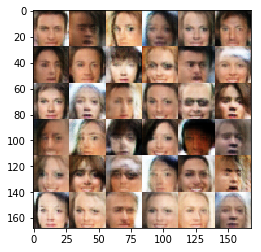

Epoch 2: Step 6326... Discriminator Loss: 1.3265... Generator Loss: 0.7418


In [57]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3



epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)